# Calculating Smectic Order Parameters
Systems with nematic order can exhibit more complex phases if positional order exists alongside orientational order. There are many different types of these phases, which are collectively known as smectic phases. The simplest smectic phase is called smectic A. In the smectic A phase, orientational order is nematic and positions are ordered into layers. This tutorial will focus on calculating the smectic order parameter for a smectic A phase.

The helper functions in the code block below will help us construct the systems we study in this notebook.

In [1]:
import freud
import matplotlib.pyplot as plt
import numpy as np
import rowan

def randomize_orientations(orientations, perturbation_magnitude):
    randomized_orientations = []
    for orientation in orientations:
        phi = np.random.uniform(0, 2 * np.pi)
        costheta = np.random.uniform(-1, 1)
        theta = np.arccos(costheta)

        perturbation = (
            np.array(
                [
                    np.sin(theta) * np.cos(phi),
                    np.sin(theta) * np.sin(phi),
                    np.cos(theta),
                ]
            )
            * perturbation_magnitude
        )

        new_orientation = orientation + perturbation
        # Normalize the new orientation vector to maintain unit length
        new_orientation /= np.linalg.norm(new_orientation)
        randomized_orientations.append(new_orientation)
    return np.array(randomized_orientations)


def generate_smectic_a_positions(
    num_particles, box_size, layer_thickness, particle_radius
):
    particles_per_layer = int(num_particles // (box_size / layer_thickness))
    num_layers = int(num_particles / particles_per_layer)

    positions = []

    for layer in range(num_layers):
        z = layer * layer_thickness + layer_thickness / 2
        particles_in_layer = 0

        while particles_in_layer < particles_per_layer:
            x = np.random.uniform(particle_radius, box_size - particle_radius)
            y = np.random.uniform(particle_radius, box_size - particle_radius)

            position = np.array([x, y, z])
            positions.append(position)
            particles_in_layer += 1

    return np.array(positions[:num_particles])


Now, lets start by constructing a system with perfect smectic and nematic order. To create perfect nematic order, we align each orientation with the z-axis. To create perfect smectic order, particles are placed in layers by the z component of their position while the x and y components are randomized.

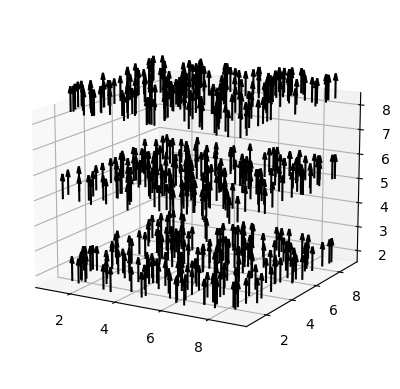

In [2]:
N = 600
box_size = 10
layer_thickness = 3.34
particle_radius = 1

points = generate_smectic_a_positions(N, box_size, layer_thickness, particle_radius)

orientations = np.asarray(
    [
        [0, 0, 1],
    ]
    * N
)

# make a 3D plot of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.quiver3D(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    orientations[:, 0],
    orientations[:, 1],
    orientations[:, 2],
    normalize=True,
    color="k",
)
# change angle of plot view
ax.view_init(elev=15)

We can compute the smectic order parameter with the following equation:
$$
P(d) = \frac{1}{N} \sum_j^N \exp( \frac{2\pi i}{d} \mathbf{n} \cdot \mathbf{r}_j) (6),
$$
where $d$ is the layer distance, $N$ is the number of particles and $\mathbf{r}$ is the position of particle. Because of the cyclial nature of complex exponentials, $P$ reaches a global maximum at specific values of the layer distance $d$. To find a value of $d$ which gives perfect smectic order, we maximize $P$ as a function of $d$. The code in the block below demonstrates this process. (A good introduction in how to compute smectic order parameters can be found in appendix of [this work](https://pubs.aip.org/aip/jcp/article/138/20/204901/566257/An-atomistic-description-of-the-nematic-and).)

In [21]:
import scipy.optimize


def calc_smectic(d, director, pos):
    return -(
        np.absolute(np.sum(np.exp(np.dot(director, pos.T) * 2 * np.pi * 1j / d)))
    ) / len(pos)


nematic = freud.order.Nematic()
nematic.compute(orientations)
# make sure the director is normalized
director = nematic.director / np.linalg.norm(nematic.director)
maximal_d = scipy.optimize.brute(
    calc_smectic,  # function to optimize
    ranges=(
        slice(layer_thickness * 0.4, layer_thickness * 1.8, 0.10),
    ),  # range of values for optimization, these depend on the size of the particles in the direction of orientation
    args=(director, points),  # arguments to pass to calc_smectic
    finish=scipy.optimize.fmin,  # use Nelder-Mead to refine the brute force result
)[0]
smec = -calc_smectic(maximal_d, director, points)
print(
    f"The value of the nematic order parameter is {nematic.order:.3f}, and the value of the smectic order parameter is {smec:.3f} and distance between the smectic layers is {maximal_d:.3f}."
)

The value of the nematic order parameter is 1.000, and the value of the smectic order parameter is 1.000 and distance between the smectic layers is 3.340.


As we can see, the system with the optimal spacing between the layers has both perfect nematic and perfect smectic order. We next consider a system with perfect smectic order, but imperfect nematic order. We achieve this by introducing orientational disorder, but keeping the layer spacing the same.

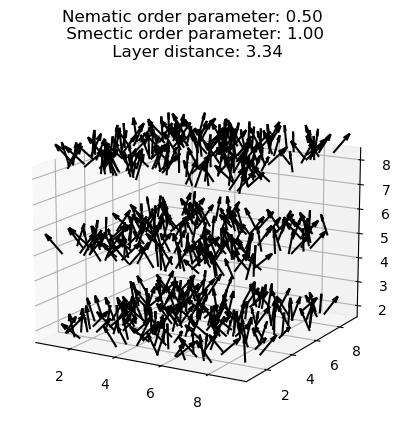

In [22]:
# generate positions and orientations
points = generate_smectic_a_positions(N, box_size, layer_thickness, particle_radius)
orientations = np.asarray(
    [
        [0, 0, 1],
    ]
    * N
)
# We randomly rotate the starting orientations by some amount
orientations = randomize_orientations(orientations, 0.75)
# compute the order paramters
nematic = freud.order.Nematic()
nematic.compute(orientations)
# make sure the director is normalized
director = nematic.director / np.linalg.norm(nematic.director)
maximal_d = scipy.optimize.brute(
    calc_smectic,  # function to optimize
    ranges=(
        slice(layer_thickness * 0.4, layer_thickness * 1.8, 0.10),
    ),  # range of values for optimization, these depend on the size of the particles in the direction of orientation
    args=(director, points),  # arguments to pass to calc_smectic
    finish=scipy.optimize.fmin,  # use Nelder-Mead to refine the brute force result
)[0]
smec = -calc_smectic(maximal_d, director, points)

# make a 3D plot of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title(
    f"Nematic order parameter: {nematic.order:.2f} \n Smectic order parameter: {smec:.2f} \n Layer distance: {maximal_d:.2f}"
)
ax.quiver3D(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    orientations[:, 0],
    orientations[:, 1],
    orientations[:, 2],
    normalize=True,
    color="k",
)
# change angle of plot view
ax.view_init(elev=15)

Lastly, we demonstrate a system with imperfect layering and imperfect orientational order. In this system, both smectic and nematic order parameters are between 0 and 1.

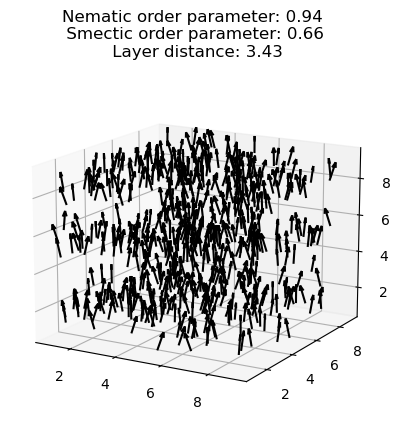

In [23]:
points = generate_smectic_a_positions(N, box_size, layer_thickness, particle_radius)
noise = np.random.normal(0, 0.5, N)
points[:, 2] = points[:, 2] + noise
# set up perfectly oriented system
orientations = np.asarray(
    [
        [0, 0, 1],
    ]
    * N
)
# We randomly rotate the starting orientations by some amount
orientations = randomize_orientations(orientations, 0.25)
# compute the order paramters
nematic = freud.order.Nematic()
nematic.compute(orientations)
# make sure the director is normalized
director = nematic.director / np.linalg.norm(nematic.director)
maximal_d = scipy.optimize.brute(
    calc_smectic,  # function to optimize
    ranges=(
        slice(layer_thickness * 0.4, layer_thickness * 1.8, 0.10),
    ),  # range of values for optimization, these depend on the size of the particles in the direction of orientation
    args=(director, points),  # arguments to pass to calc_smectic
    finish=scipy.optimize.fmin,  # use Nelder-Mead to refine the brute force result
)[0]
smec = -calc_smectic(maximal_d, director, points)

# make a 3D plot of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title(
    f"Nematic order parameter: {nematic.order:.2f} \n Smectic order parameter: {smec:.2f} \n Layer distance: {maximal_d:.2f}"
)
ax.quiver3D(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    orientations[:, 0],
    orientations[:, 1],
    orientations[:, 2],
    normalize=True,
    color="k",
)
# change angle of plot view
ax.view_init(elev=15)